In [1]:
#imports
import pandas as pd
import numpy as np
import datetime
%matplotlib inline
import matplotlib.pyplot as plttouches

In [2]:
import pandas.io.sql as psql
import psycopg2
connection = psycopg2.connect('yourdbhere')

In [3]:
#leskeddit
#https://github.com/facebook/prophet
#https://facebook.github.io/prophet/docs/quick_start.html
from fbprophet import Prophet

In [4]:
df = pd.read_sql("SELECT kiosk, date, transaction_id, amount_paid FROM yourdb WHERE CONVERT(datetime,date) >= '01-01-2016'", connection)

Some background on our physical presence, our company makes kiosks that can record key/rfid/general security information. These kiosks are placed in partner stores such as 7-11, Acme, etc. Each kiosk has a unique identifier, but kiosks get swapped between stores, get replaced, and so on. Each transaction is stored with the kiosk information, not the store information. When tracking our sales over time, this presents a relatively annoying problem. We care way more about how a particular store is doing than what kiosk is associated with it, but we didn't actually start tracking store to kiosk until mid 2016. #startupprobz

I want to know about how our stores are doing over time, because I'm worried about... say, declining return when we pump out new kiosks and oversaturate markets. I'm going to only look at kiosks that were active for the entire date range. Then I'll show a really quick method of removing outliers using the rolling median. Finally, I'll throw in a few extra changepoints for major changes to our kiosks and we can see how much of an effect they actually had. Then I'll use Prophet's built in testing methods to see how well their model stacks up.

In [5]:
df[['Created At 2', 'Created At 3', 'Created At 4']] = df['date'].str.split(expand = True)
df.drop(['date', 'Created At 3', 'Created At 4'],inplace=True,axis=1)
df = df.rename(index=str, columns={"Created At 2": "Created At"})


In [6]:
df['amount_paid'] = pd.to_numeric(df['amount_paid'], errors='coerce')

In [7]:
df['snapshot_time'] = pd.to_datetime(df['Created At'], format='%m/%d/%Y')

In [8]:
dfkiosks = pd.read_sql("SELECT name, banner, store_number, snapshot_time FROM keyme_production.kiosk_history WHERE deployed = TRUE", connection)

I'm sure there's a better way of doing this but... I'm going to take the list of stores that are deployed first month, then the list that's deployed right now. This gives me two lists of stores, from there I get the stores and kiosks with the date, and I merge back onto the main. This is the theory. I think merging instead of using lists might be faster with more data. 

In [9]:
dfkiosks['banner_store_number'] = dfkiosks['banner']+dfkiosks['store_number'].map(str)
dfkiosks['Month Cohort'] = dfkiosks['snapshot_time'].values.astype('datetime64[M]')
beginning = dfkiosks[dfkiosks['Month Cohort'] == datetime.date(2016,6,1)]['banner_store_number'].tolist()
end = dfkiosks[dfkiosks['Month Cohort'] == datetime.date(2018,1,1)]['banner_store_number'].tolist()

In [10]:
dfkiosks = dfkiosks[(dfkiosks['banner_store_number'].isin(beginning))&(dfkiosks['banner_store_number'].isin(end))]

In [11]:
dfkiosks.head()

,name,banner,store_number,snapshot_time,banner_store_number,Month Cohort
13,FM101,7-Eleven,33729.0,2016-06-18,7-Eleven33729.0,2016-06-01
14,FM101,7-Eleven,33729.0,2016-06-20,7-Eleven33729.0,2016-06-01
15,FM101,7-Eleven,33729.0,2016-06-21,7-Eleven33729.0,2016-06-01
16,FM101,7-Eleven,33729.0,2016-06-24,7-Eleven33729.0,2016-06-01
17,FM101,7-Eleven,33729.0,2016-06-25,7-Eleven33729.0,2016-06-01


Okay let's clean up my dataframes a bit and then merge them back together. Not using standard naming is one of my eternal pet peeves, but what can you do?

In [12]:
dfkiosks.drop(['banner', 'store_number', 'Month Cohort'], axis=1, inplace=True)
df.drop(['Created At'], axis=1, inplace=True)
df.rename(index=str, columns={"kiosk": "name"}, inplace=True)

In [13]:
dfcontinuous = df.merge(dfkiosks, on=['name', 'snapshot_time'], how='inner')

In [14]:
dfcontinuous = dfcontinuous.groupby(['snapshot_time'], as_index=False).agg({"amount_paid":"sum"}).reset_index()

In [15]:
dfcontinuous.head()

,index,snapshot_time,amount_paid
0,0,2016-06-16,3578.54
1,1,2016-06-17,3849.24
2,2,2016-06-18,3576.53
3,3,2016-06-19,4329.92
4,4,2016-06-20,3486.05


In [16]:
dfcontinuous.drop(['index'], axis=1, inplace=True)

In [17]:
dfcontinuous.rename(index=str, columns={"snapshot_time": "ds", "amount_paid":"y"}, inplace=True)

/Users/ben.jiang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=True).median()
  """


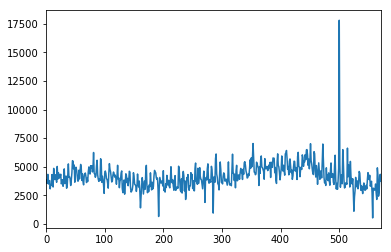

In [18]:
from pandas import rolling_median

kw = dict(marker='o', linestyle='none', color='r', alpha=0.3)
threshold = 1000
dfcontinuous['median'] = rolling_median(dfcontinuous['y'], window=5, center=True).fillna(method='bfill').fillna(method='ffill')

dfcontinuous['difference'] = np.abs(dfcontinuous['y'] - dfcontinuous['median'])
dfcontinuous['outlier_idx'] = dfcontinuous['difference'] > threshold

dfcontinuous['y'].plot()


So if you're paying attention, I just took the rolling median of the y values and tagged those y values that are more than 250 off from the rolling median as an outlier. First let's see what our model looks like with the outliers still there

In [19]:
m = Prophet(yearly_seasonality=True)

In [20]:
m.fit(dfcontinuous)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
932,2019-01-04
933,2019-01-05
934,2019-01-06
935,2019-01-07
936,2019-01-08


In [22]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
932,2019-01-04,2092.124358,1097.823471,3192.129084
933,2019-01-05,2967.897355,1913.390629,3950.476237
934,2019-01-06,3504.240543,2356.220184,4572.158167
935,2019-01-07,2701.122406,1668.553950,3746.392994
936,2019-01-08,2367.415184,1197.251951,3410.483065


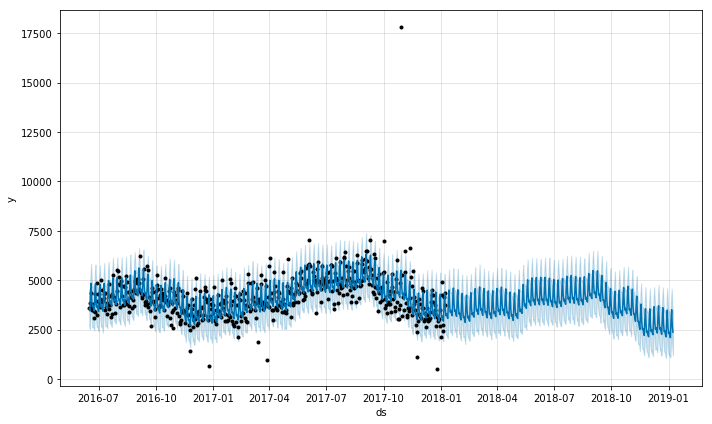

In [23]:
m.plot(forecast);

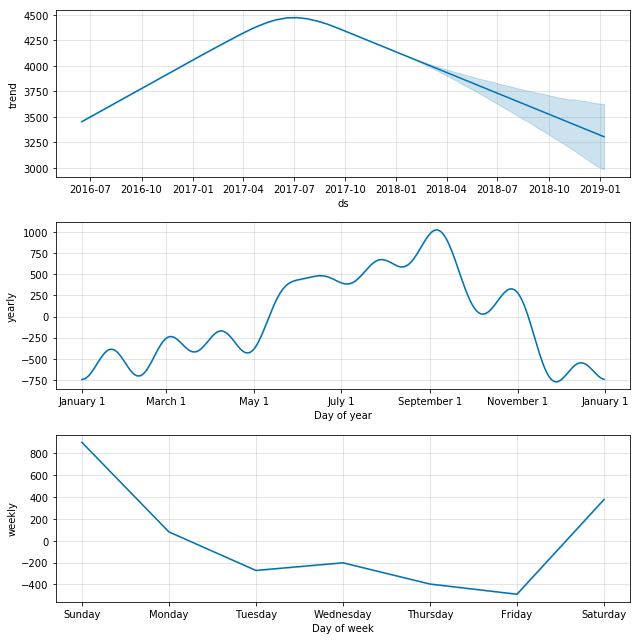

In [24]:
m.plot_components(forecast);

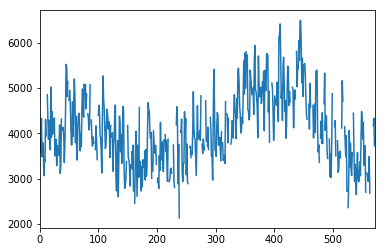

In [25]:
dfcontinuous.loc[(dfcontinuous['outlier_idx'] == True), 'y'] = None
dfcontinuous['y'].plot()

One major advantage of Prophet in my experience is that it handles missing values pretty well. No messing around and setting your outliers to 'normal' values, just kill them all and let God (aka Prophet) sort em out. 

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


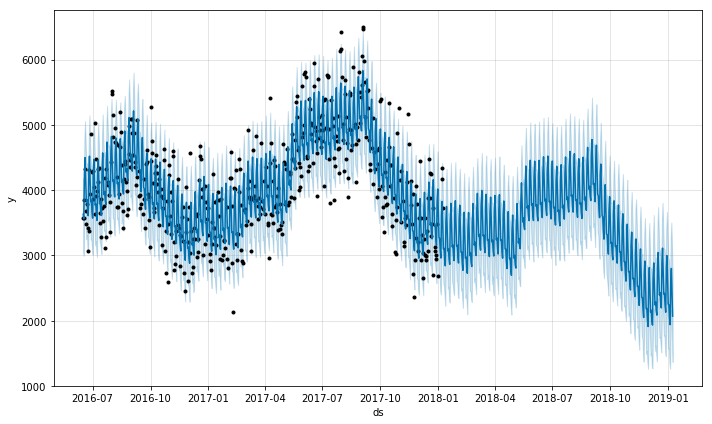

In [26]:
m = Prophet(yearly_seasonality=True)
m.fit(dfcontinuous)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
m.plot(forecast);

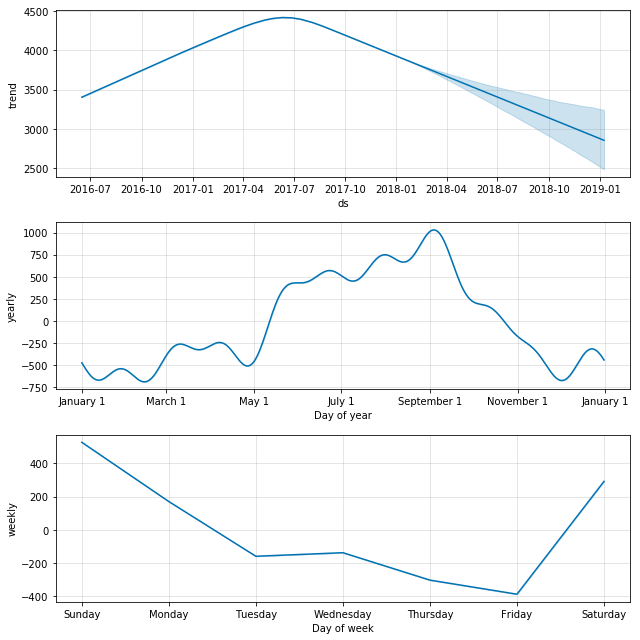

In [27]:
m.plot_components(forecast);

Now I'm going to switch over from automatic changepoints to manual changepoints. These were projects I worked, so I'm positive about these dates.

Just kidding, this apparently crashes my kernel and I can't get it running. Try at your own risk

m = Prophet(changepoints=['2017-10-01', '2017-11-14'])
forecast = m.fit(dfcontinuous).predict(future)
m.plot(forecast);

In [29]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, horizon = '90 days')
df_cv.head()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-04-14,3389.972566,2876.008870,3908.951821,4148.12,2017-04-13
1,2017-04-15,3920.081536,3399.354353,4449.560303,4459.82,2017-04-13
2,2017-04-16,4230.832717,3720.489791,4751.249388,4375.46,2017-04-13
3,2017-04-17,3642.019563,3113.996382,4147.735646,3740.27,2017-04-13
4,2017-04-18,3291.667080,2719.460746,3788.114685,3778.90,2017-04-13


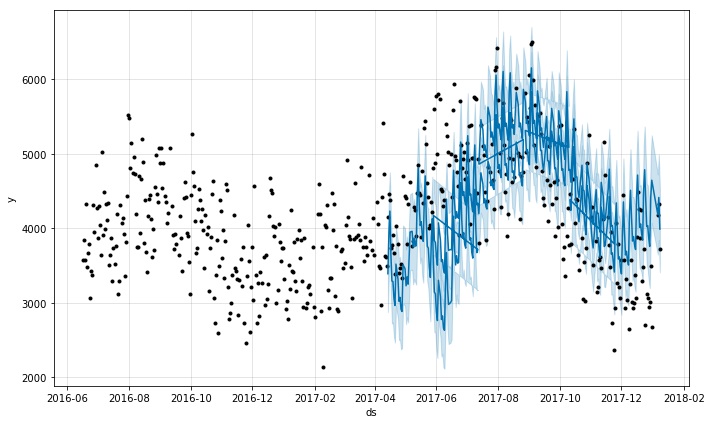

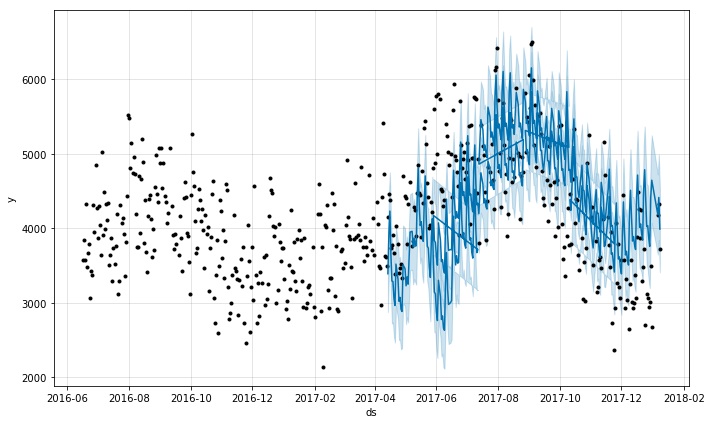

In [38]:
m.plot(df_cv)

It's doing something weird when I attempt to feed it into the same plotting format as the previous ones, but you get the drift. Without playing around with the tuning of the model, Prophet provides the best free, out of the box solution I've found for doing time series analysis. It runs pretty fast (I've shoved in millions of transactions into it and it runs in a few minutes) and it handles user defined holidays really well in my experience. I'm not sure why adding custom changepoints is now crashing my kernel though. 